# Amazon Product Data Preprocessing v2

This notebook performs advanced preprocessing for data mining on the `Amazon-Products.csv` dataset. 
Major features included:
- Exploratory Data Analysis (EDA)
- Data Visualization (Distributions, Heatmaps, Outliers)
- Cleaning and Currency Conversion (INR to USD)
- Filtering Zero Prices
- Categorical Encoding
- Unique ID Generation

In [18]:
%pip install pandas numpy matplotlib seaborn scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import os
import re
import glob

# Paths
input_path = '../dataset/Amazon-Products.csv'
output_dir = '../pre_processing'
base_filename = 'Amazon-Products_processed'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Find the next serial number
existing_files = glob.glob(os.path.join(output_dir, f"{base_filename}_*.csv"))
if existing_files:
    numbers = []
    for f in existing_files:
        match = re.search(rf"{base_filename}_(\d+)\.csv$", f)
        if match:
            numbers.append(int(match.group(1)))
    next_num = max(numbers) + 1 if numbers else 1
else:
    next_num = 1

output_filename = f"{base_filename}_{next_num:02d}.csv"
output_path = os.path.join(output_dir, output_filename)

print(f"Loading {input_path}...")
df = pd.read_csv(input_path)
print(f"Output will be saved to: {output_path}")

Loading ../dataset/Amazon-Products.csv...
Output will be saved to: ../pre_processing\Amazon-Products_processed_02.csv


## 1. Raw Data Exploration

In [20]:
print("### Dataset Info ###")
df.info()

print("\n### Dataset Statistics ###")
display(df.describe(include='all'))

### Dataset Info ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551585 entries, 0 to 551584
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      551585 non-null  int64 
 1   name            551585 non-null  object
 2   main_category   551585 non-null  object
 3   sub_category    551585 non-null  object
 4   image           551585 non-null  object
 5   link            551585 non-null  object
 6   ratings         375791 non-null  object
 7   no_of_ratings   375791 non-null  object
 8   discount_price  490422 non-null  object
 9   actual_price    533772 non-null  object
dtypes: int64(1), object(9)
memory usage: 42.1+ MB

### Dataset Statistics ###


,Unnamed: 0,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
count,551585.000000,551585,551585,551585,551585,551585,375791,375791,490422,533772
unique,NaN,396210,20,112,462414,551585,49,8342,27511,23170
top,NaN,Zeya Yellow Gold Ring,accessories,Formal Shoes,https://m.media-amazon.com/images/I/51uEPldT42...,https://www.amazon.in/Mothercare-Carrot-Regula...,4.0,1,₹499,₹999
freq,NaN,718,116141,19200,3044,1,36609,39816,18248,48774
mean,7006.200471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,5740.835523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1550.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5933.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,11482.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.1 Missing Values Heatmap

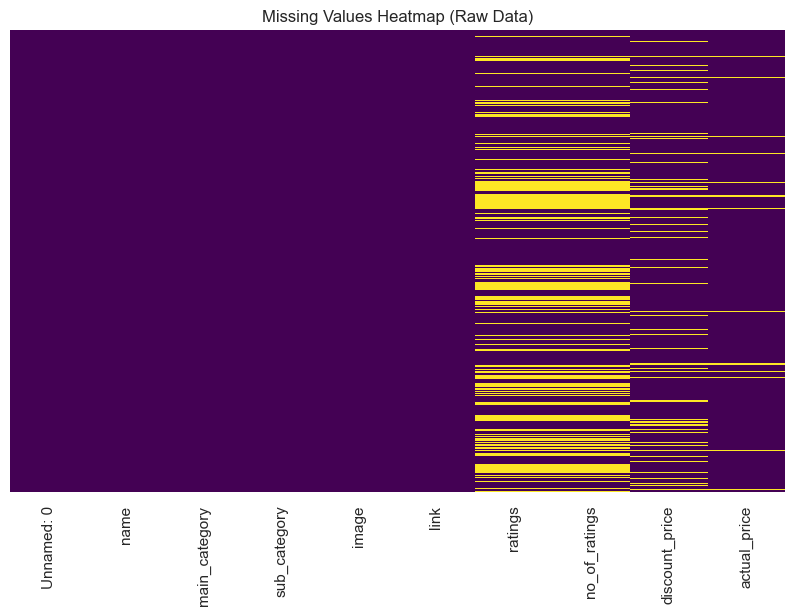

In [21]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Values Heatmap (Raw Data)")
plt.show()

### 1.2 Categorical Distribution (Main Category)

C:\Users\Admin\AppData\Local\Temp\ipykernel_29184\478287865.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='main_category', data=df, order=df['main_category'].value_counts().index, palette='magma')


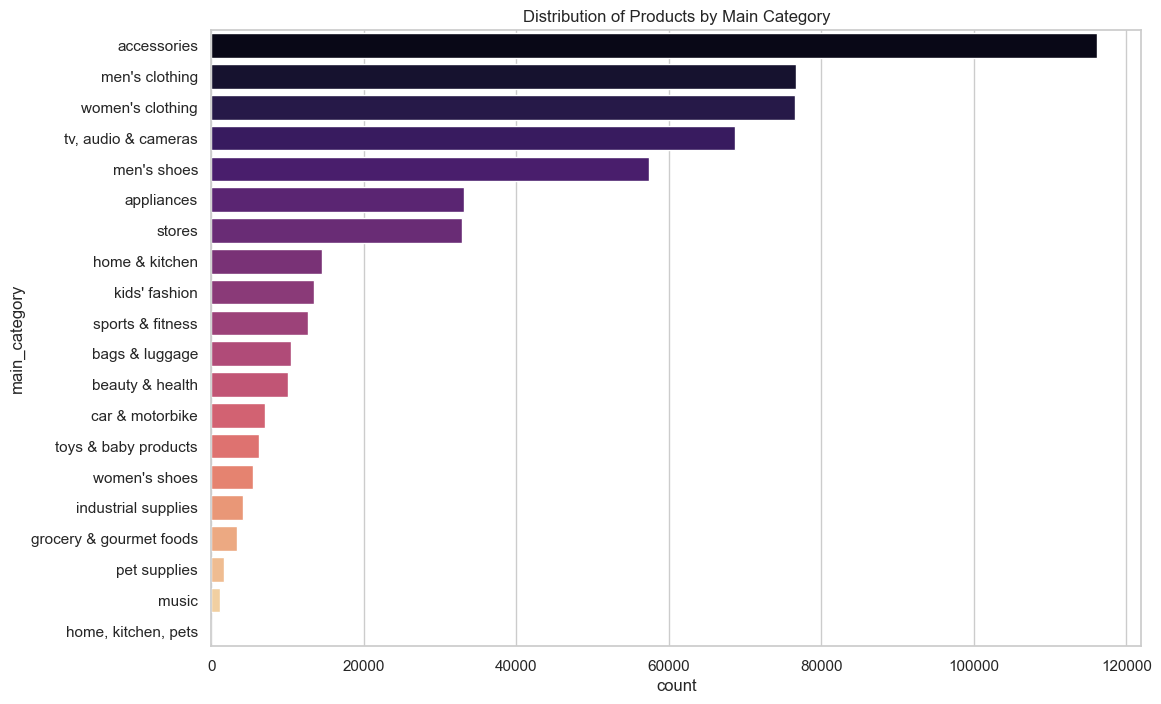

In [22]:
sns.countplot(y='main_category', data=df, order=df['main_category'].value_counts().index, palette='magma')
plt.title("Distribution of Products by Main Category")
plt.show()

## 2. Data Cleaning & Feature Engineering

In [23]:
def clean_price(price_str):
    if pd.isna(price_str) or price_str == '':
        return 0.0
    # Remove currency symbols and commas
    clean_str = re.sub(r'[^\d.]', '', str(price_str).replace('₹', '').replace('窜ｹ', '').replace(',', ''))
    try:
        return float(clean_str)
    except ValueError:
        return 0.0

def clean_ratings_count(count):
    if pd.isna(count) or count == '':
        return 0.0
    try:
        return float(str(count).replace(',', '').replace('"', ''))
    except ValueError:
        return 0.0

print("Cleaning numeric columns...")
df['discount_price'] = df['discount_price'].apply(clean_price)
df['actual_price'] = df['actual_price'].apply(clean_price)
df['no_of_ratings'] = df['no_of_ratings'].apply(clean_ratings_count)
df['ratings'] = pd.to_numeric(df['ratings'], errors='coerce').fillna(0.0)

# Currency Conversion
exchange_rate = 83.0 # Approx INR to USD
df['discount_price_usd'] = (df['discount_price'] / exchange_rate).round(2)
df['actual_price_usd'] = (df['actual_price'] / exchange_rate).round(2)

Cleaning numeric columns...


### 2.1 Filtering Zero Prices
Removing rows where prices are zero as they represent missing or invalid data for data mining.

In [24]:
initial_count = len(df)
df = df[(df['discount_price_usd'] > 0) & (df['actual_price_usd'] > 0)]
final_count = len(df)
print(f"Rows removed: {initial_count - final_count} ({((initial_count - final_count)/initial_count)*100:.2f}%)")

Rows removed: 61163 (11.09%)


### 2.2 Encoding & ID Generation

In [25]:
print("Encoding categories...")
le_main = LabelEncoder()
df['main_category_encoded'] = le_main.fit_transform(df['main_category'].astype(str))
le_sub = LabelEncoder()
df['sub_category_encoded'] = le_sub.fit_transform(df['sub_category'].astype(str))

prefix_map = {
    'home & kitchen': 'hkt',
    'appliances': 'apl',
    'electronics': 'ele',
    'accessories': 'acs',
    'toys & games': 'toy',
    'beauty & health': 'bth',
    'grocery & gourmet foods': 'gro',
    'sports & outdoors': 'spo',
    'clothing & accessories': 'cla',
    'shoes': 'sho'
}

def generate_id(row):
    cat = str(row['main_category']).lower()
    prefix = 'prd'
    for key, val in prefix_map.items():
        if key in cat:
            prefix = val
            break
    return f"{prefix}{row.name:06d}"

print("Generating unique IDs...")
# Reset index to ensure row.name is unique and sequential after filtering
df = df.reset_index(drop=True)
df['id'] = df.apply(generate_id, axis=1)

Encoding categories...
Generating unique IDs...


## 3. Post-Processing Analysis & Visualization

In [26]:
print("### Processed Dataset Info ###")
df.info()
display(df.describe())

### Processed Dataset Info ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490422 entries, 0 to 490421
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             490422 non-null  int64  
 1   name                   490422 non-null  object 
 2   main_category          490422 non-null  object 
 3   sub_category           490422 non-null  object 
 4   image                  490422 non-null  object 
 5   link                   490422 non-null  object 
 6   ratings                490422 non-null  float64
 7   no_of_ratings          490422 non-null  float64
 8   discount_price         490422 non-null  float64
 9   actual_price           490422 non-null  float64
 10  discount_price_usd     490422 non-null  float64
 11  actual_price_usd       490422 non-null  float64
 12  main_category_encoded  490422 non-null  int64  
 13  sub_category_encoded   490422 non-null  int64  
 14  id   

,Unnamed: 0,ratings,no_of_ratings,discount_price,actual_price,discount_price_usd,actual_price_usd,main_category_encoded,sub_category_encoded
count,490422.000000,490422.00000,490422.000000,4.904220e+05,4.904220e+05,490422.000000,4.904220e+05,490422.000000,490422.000000
mean,6960.819947,2.60525,583.197793,2.623161e+03,2.465067e+04,31.604399,2.969963e+02,9.445286,56.255566
std,5720.709645,1.88110,7358.625641,9.458196e+03,1.413704e+07,113.954165,1.703258e+05,6.940237,30.379326
min,0.000000,0.00000,0.000000,8.000000e+00,1.000000e+01,0.100000,1.200000e-01,0.000000,0.000000
25%,1538.000000,0.00000,0.000000,3.890000e+02,9.990000e+02,4.690000,1.204000e+01,1.000000,35.000000
50%,5893.000000,3.50000,5.000000,6.790000e+02,1.599000e+03,8.180000,1.927000e+01,10.000000,55.000000
75%,11383.000000,4.00000,52.000000,1.399000e+03,2.999000e+03,16.860000,3.613000e+01,17.000000,85.000000
max,19199.000000,5.00000,589547.000000,1.249990e+06,9.900000e+09,15060.120000,1.192771e+08,19.000000,111.000000


### 3.1 Price Distribution (Log Scale)

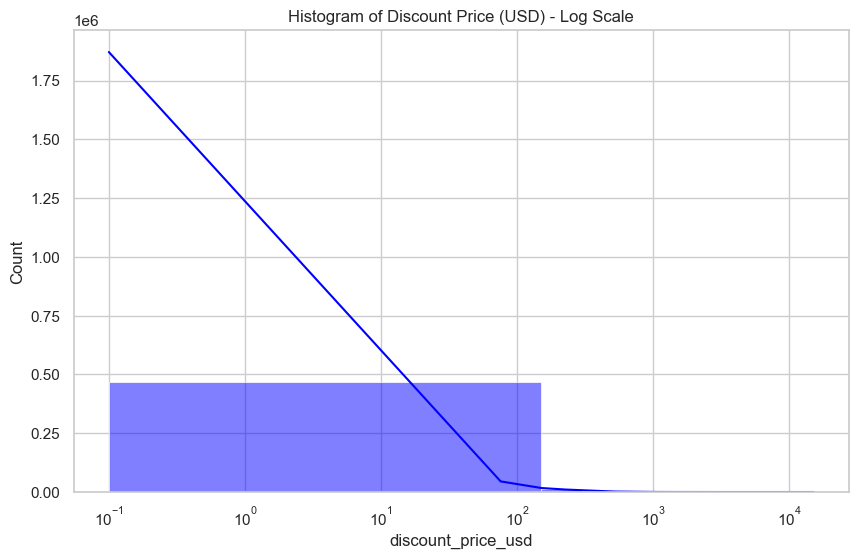

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(df['discount_price_usd'], bins=100, kde=True, color='blue')
plt.xscale('log')
plt.title("Histogram of Discount Price (USD) - Log Scale")
plt.show()

### 3.2 Outlier Analysis (Boxplot)

C:\Users\Admin\AppData\Local\Temp\ipykernel_29184\3249618017.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='main_category', y='ratings', data=df, palette='Set3')


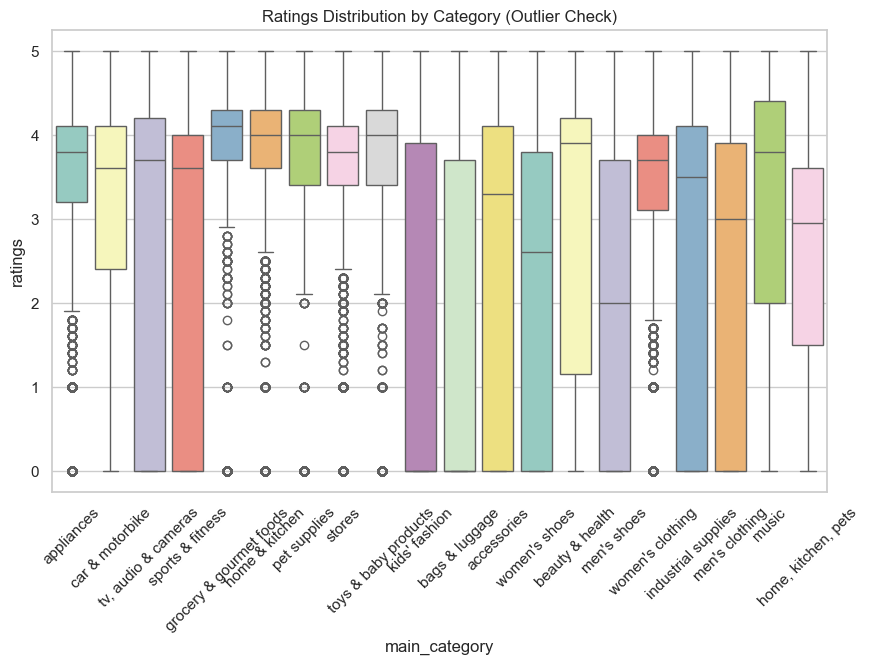

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='main_category', y='ratings', data=df, palette='Set3')
plt.xticks(rotation=45)
plt.title("Ratings Distribution by Category (Outlier Check)")
plt.show()

### 3.3 Correlation Heatmap

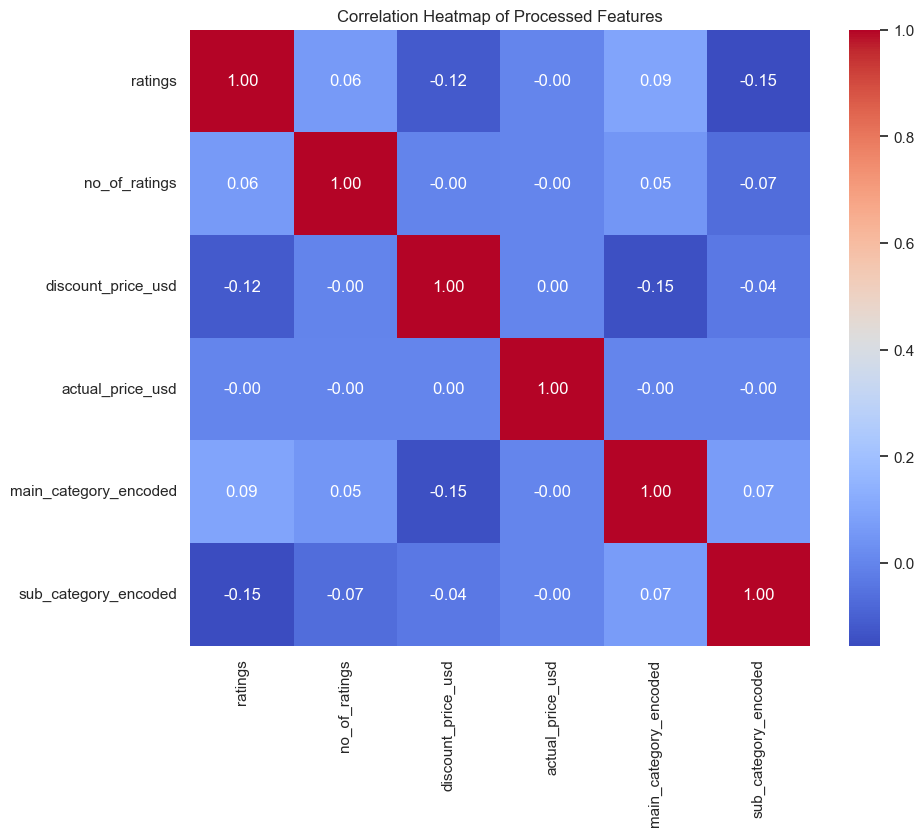

In [29]:
numeric_cols = ['ratings', 'no_of_ratings', 'discount_price_usd', 'actual_price_usd', 
                'main_category_encoded', 'sub_category_encoded']
corr = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Processed Features")
plt.show()

## 4. Final Export

In [30]:
final_cols = [
    'id', 'name', 'main_category', 'main_category_encoded', 
    'sub_category', 'sub_category_encoded', 'image', 'link', 
    'ratings', 'no_of_ratings', 'discount_price_usd', 'actual_price_usd'
]

print(f"Saving processed data to {output_path}...")
df[final_cols].to_csv(output_path, index=False)
print("Preprocessing v2 Complete!")

Saving processed data to ../pre_processing\Amazon-Products_processed_02.csv...
Preprocessing v2 Complete!
